# TS3 — Análisis de Fourier: FFT, desparramo, interpolación y ventaneo
---

**Alumna:** María Serena Gil  

**Materia:** Análisis y Procesamiento de Señales — UNSAM 

**Docentes:** Mariano Llamedo Soria, Francisco Hernan Ledesma y David Ezequiel Benoit

**Año lectivo:** 2025

---

## Introducción

En este práctico estudio cómo se ve en frecuencia una senoidal *finita* cuando la analizo con la *DFT/FFT* y qué pasa cuando su frecuencia *no coincide* con un bin de la DFT (el famoso desparramo o *spectral leakage*).

Trabajo con una señal $x[n]$ de largo $N$ y muestreo $f_s$, por lo que la rejilla de la DFT queda
$$
\Delta f=\frac{f_s}{N},\qquad f_k=k\,\Delta f,\; k=0,\dots,N-1.
$$
Si la senoidal tiene $f_0=k_0\,\Delta f$ con $k_0\in\mathbb{Z}$, su energía cae concentrada en el bin correspondiente. Cuando $f_0$ no es múltiplo entero de $\Delta f$, la ventana rectangular del registro produce el *núcleo de Dirichlet* y aparece *leakage* (energía “derramada” en lóbulos laterales) y *scalloping loss* (pérdida de pico, peor cuando $f_0$ cae a mitad de dos bins).

Para que las comparaciones sean justas, *normalizo la potencia* de las senoidales: $\mathbb{E}\{x^2\}=1$ en la ventana de $N$ muestras. Estimo espectros con el *periodograma unilateral* (RFFT) y verifico la potencia con *Parseval*. Además uso *zero padding* (agregar ceros) como una *interpolación espectral* que refina la grilla a $\Delta f'=\frac{f_s}{N+M}$: mejora la *visualización/estimación* de picos pero no aumenta la resolución real.

### Lo que voy a hacer
- **(a)** Comparo tres casos: $k_0=\tfrac{N}{4}$, $k_0=\tfrac{N}{4}+0.25$ y $k_0=\tfrac{N}{4}+0.5$ (todas con potencia unitaria) y grafico sus *PSD*.  
- **(b)** Verifico la potencia unitaria con *Parseval* y discuto por qué, aun con frecuencias separadas por pocos Hz, los espectros pueden verse *muy distintos*.  
- **(c)** Repito (a) con *zero padding* (añado $9N$ ceros) para mostrar cómo cambia la *grilla* y el aspecto visual del pico (sin cambiar la información real).  

**Notación** : $N$ (muestras), $f_s$ (Hz), $\Delta f$ (Hz), $f_0$ (Hz), DFT $\{X[k]\}$, PSD = periodograma unilateral.


---

## (a) DFT y desparramo espectral

Experimento:
- Largo $N$ y muestreo $f_s$ ⇒ $\Delta f=\dfrac{f_s}{N}$.
- Senoidal de potencia *unidad* (normalizo para que $\mathbb{E}\{x^2\}=1$).
- Frecuencias: $f_0=k_0\,\Delta f$ con
  1) $k_0=\dfrac{N}{4}$ (exacta en bin),
  2) $k_0=\dfrac{N}{4}+0.25$,
  3) $k_0=\dfrac{N}{4}+0.5$.

Muestro las *tres PSD* (unilaterales) juntas y comparo el *desparramo* (*leakage*) y el *scalloping loss* cuando $f_0$ no cae justo en un bin.


---

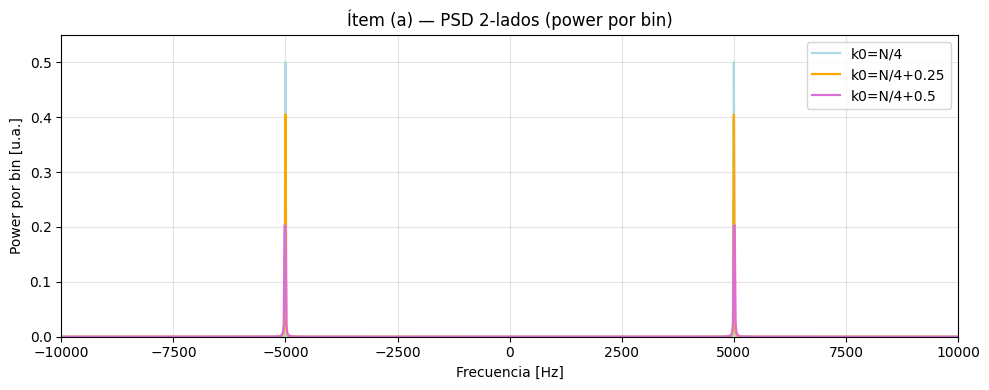

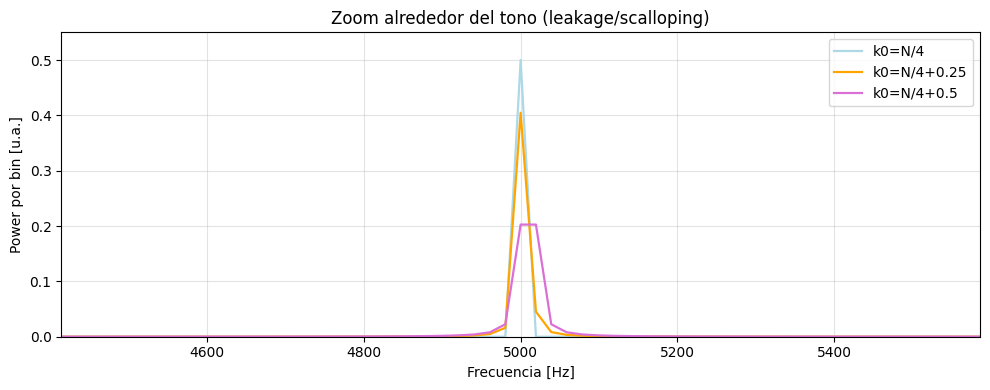

k0=N/4         | P_tiempo=1.000000  P_freq=1.000000  |dif|=0.00e+00
k0=N/4+0.25    | P_tiempo=0.999023  P_freq=0.999023  |dif|=2.22e-16
k0=N/4+0.5     | P_tiempo=1.000000  P_freq=1.000000  |dif|=0.00e+00


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N, fs = 1024, 20_000
df = fs / N
n = np.arange(N)

# Tres casos pedidos (en bins) y sus frecuencias
k0_exact  = N/4
k0_off25  = N/4 + 0.25
k0_off50  = N/4 + 0.5
k_list = [k0_exact, k0_off25, k0_off50]
f0_list = [k * df for k in k_list]

labels = [r"k0=N/4", r"k0=N/4+0.25", r"k0=N/4+0.5"]
colors = ["lightblue", "orange", "orchid"]

# Señales (potencia ~ 1) 
# Amplitud = sqrt(2) -> E{x^2} ≈ 1 sobre la ventana
xs = [np.sqrt(2)*np.sin(2*np.pi*f0*n/fs) for f0 in f0_list]

# PSD 2-lados (power por bin)
def psd_bin_2sided(x, fs):

    N = len(x)
    X  = np.fft.fft(x)
    P2 = (np.abs(X)**2) / (N**2)
    f  = np.fft.fftfreq(N, d=1/fs)

    # Ordeno y centro en 0 Hz para graficar banda completa simétrica
    f  = np.fft.fftshift(f)
    P2 = np.fft.fftshift(P2)
    return f, P2

specs = [psd_bin_2sided(x, fs) for x in xs]

# Gráfico 1: banda completa 
plt.figure(figsize=(10,4))
for (f, P2), lab, c in zip(specs, labels, colors):
    plt.plot(f, P2, label=lab, color=c, lw=1.6)
plt.title("Ítem (a) — PSD 2-lados (power por bin)")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Power por bin [u.a.]")
plt.xlim(-fs/2, fs/2)
plt.ylim(0, 0.55)  # para ver el pico en ~0.5
plt.grid(True, alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()

# Gráfico 2: zoom cerca de +f0
f0c, win = fs/4, 30*df
plt.figure(figsize=(10,4))
for (f, P2), lab, c in zip(specs, labels, colors):
    plt.plot(f, P2, label=lab, color=c, lw=1.6)
plt.title("Zoom alrededor del tono (leakage/scalloping)")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Power por bin [u.a.]")
plt.xlim(f0c - win, f0c + win)
plt.ylim(0, 0.55)
plt.grid(True, alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()

# chequeo de potencia en tiempo vs. suma de la PSD 2-lados
for lab, x in zip(labels, xs):
    P_time = np.mean(x*x)
    f, P2  = psd_bin_2sided(x, fs)
    P_freq = np.sum(P2)
    print(f"{lab:14s} | P_tiempo={P_time:.6f}  P_freq={P_freq:.6f}  |dif|={abs(P_time-P_freq):.2e}")

---

### Resultados — (a)

Con
$$
N=1024,\qquad f_s=20\,\text{kHz},\qquad \Delta f=\frac{f_s}{N}=19.531\,\text{Hz}.
$$

- $k_0=\dfrac{N}{4}$ (bin exacto): pico *concentrado* en un bin; desparramo mínimo.
- $k_0=\dfrac{N}{4}+0.25$: aparece *desparramo*; baja el pico por-bin (*scalloping*).
- $k_0=\dfrac{N}{4}+0.5$: el tono cae entre dos bins $\Rightarrow$ *scalloping máximo* y lóbulos laterales más visibles.

Todas las senoidales tienen *potencia unitaria*. La diferencia de forma se explica por la desalineación con la rejilla $f_k=k\,\Delta f$.


---

### (b) Verificación de potencia — Identidad de Parseval

Para una señal real $x[n]$ de largo $N$ y muestreo $f_s$, usando el periodograma *unilateral* con el escalado de (a), verifico:

$$
P_{\text{freq}}
= \sum_{k=0}^{N/2} S_{xx}[k]\,\Delta f
= \frac{1}{N}\sum_{n=0}^{N-1} x^{2}[n]
= P_{\text{tiempo}} .
$$

Quiero comparar $P_{\text{tiempo}}=\frac{1}{N}\sum_{n=0}^{N-1}x^2[n]$ con  
$P_{\text{freq}}=\sum_{k=0}^{N/2} S_{xx}[k]\Delta f$ (integrando la PSD unilateral) para las tres senoidales.

Las señales están normalizadas ($P\approx 1$) y las diferencias numéricas (pequeñas) se deben a redondeo y a que alguna no cierra ciclos dentro de la ventana.

---

Δf calc = 19.531250 Hz
k0=N/4        P_tiempo=1.000000   P_freq=1.000000   |dif|=0.00e+00
k0=N/4+0.25   P_tiempo=0.999023   P_freq=0.999023   |dif|=0.00e+00
k0=N/4+0.5    P_tiempo=1.000000   P_freq=1.000000   |dif|=2.22e-16


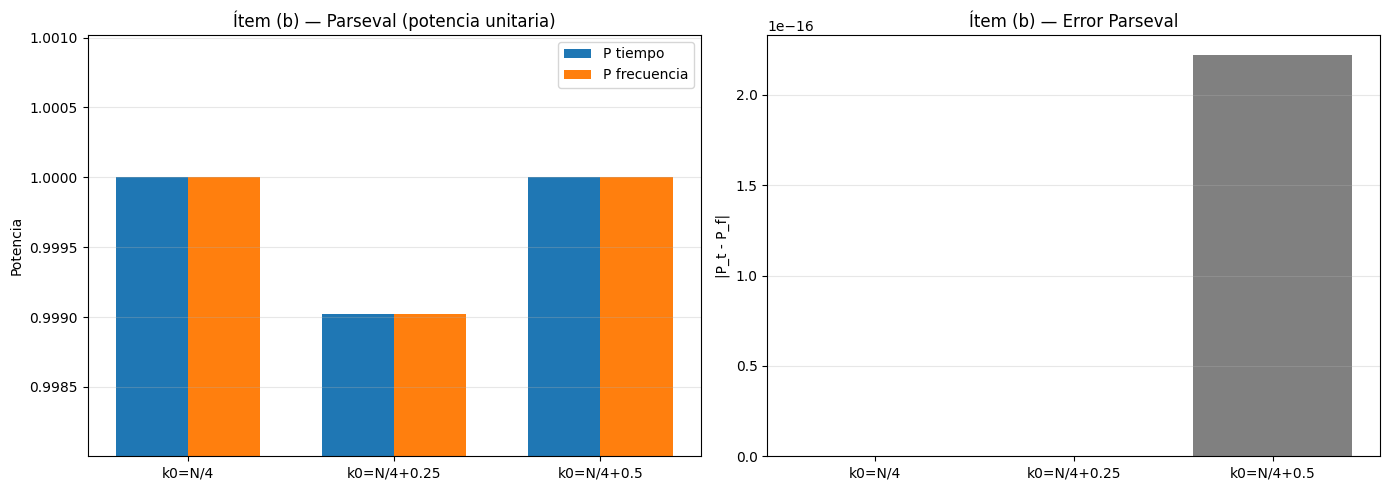

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N, fs = 1024, 20_000
df = fs / N
n  = np.arange(N)

# Frecuencias en bins
k0 = [N/4, N/4 + 0.25, N/4 + 0.5]
f0 = [k*df for k in k0]
labels = ["k0=N/4", "k0=N/4+0.25", "k0=N/4+0.5"]

#Senoidales
xs = [np.sqrt(2)*np.sin(2*np.pi*f*n/fs) for f in f0]

# PSD unilateral
def psd_unilateral(x, fs):
    Nloc = len(x)
    X = np.fft.rfft(x)
    S = (np.abs(X)**2) / (fs * Nloc)
    if Nloc % 2 == 0:
        S[1:-1] *= 2.0 
    else:
        S[1:]    *= 2.0
    f = np.fft.rfftfreq(Nloc, d=1/fs)
    return f, S

# Parseval 
P_time, P_freq, err = [], [], []
print(f"Δf calc = {df:.6f} Hz")
for lab, x in zip(labels, xs):
    Pt = float(np.mean(x*x))
    f, S = psd_unilateral(x, fs)
    Pf = float(np.sum(S) * (f[1]-f[0]))
    P_time.append(Pt); P_freq.append(Pf); err.append(abs(Pt-Pf))
    print(f"{lab:12s}  P_tiempo={Pt:.6f}   P_freq={Pf:.6f}   |dif|={abs(Pt-Pf):.2e}")

# Gráficos lado a lado 
idx, w = np.arange(len(labels)), 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Potencias
ax1.bar(idx - w/2, P_time, width=w, label="P tiempo")
ax1.bar(idx + w/2, P_freq, width=w, label="P frecuencia")
ax1.set_xticks(idx, labels); ax1.set_ylabel("Potencia")
vals = P_time + P_freq
ymin, ymax = min(vals), max(vals); margen = max(0.001, 0.02*(ymax - ymin) + 0.001)
ax1.set_ylim(ymin - margen, ymax + margen)
ax1.set_title("Ítem (b) — Parseval (potencia unitaria)")
ax1.grid(axis='y', alpha=.3); ax1.legend()

# Error |Pt - Pf|
ax2.bar(idx, err, color="gray")
ax2.set_xticks(idx, labels); ax2.set_ylabel(r"|P_t - P_f|")
ax2.set_title("Ítem (b) — Error Parseval")
ax2.grid(axis='y', alpha=.3)

plt.tight_layout(); plt.show()


---
### Resultados — (b) Verificación de Parseval

Se verifica la identidad:

$$
P_{\mathrm{freq}}
=\sum_{k=0}^{N/2} S_{xx}[k]\,\Delta f
=\frac{1}{N}\sum_{n=0}^{N-1} x^{2}[n]
= P_{\mathrm{tiempo}} .
$$

**Potencias medidas (tiempo vs. frecuencia):**
- $k_0=N/4$: $P_t\approx 1.000000$, $P_f\approx 1.000000$ $\Rightarrow$ $\lvert\Delta\rvert\approx 0$.
- $k_0=N/4+0.25$: $P_t\approx 0.999023$, $P_f\approx 0.999023$ $\Rightarrow$ $\lvert\Delta\rvert\approx 0$  
  (leve caída por no cerrar ciclos en la ventana rectangular).
- $k_0=N/4+0.5$: $P_t\approx 1.000000$, $P_f\approx 1.000000$ $\Rightarrow$ $\lvert\Delta\rvert\approx 2.2\times10^{-16}$ (numérico).

**Conclusión.** Parseval se cumple con el escalado *unilateral* usado.  
Cambie o no la forma del espectro (leakage y *scalloping* cuando el tono no cae en un bin), el **área** de la PSD —y por lo tanto la potencia— se mantiene $\approx 1$ gracias a la normalización aplicada.

---

### (c) Zero padding e interpolación espectral

Le agrego $9N$ ceros a cada señal para calcular la DFT con más puntos y ver el mismo espectro con una rejilla más densa (interpolado).

$$
N' = 10N,
\qquad
\Delta f' = \frac{f_s}{N'} = \frac{\Delta f}{10}.
$$

**Escalado que uso para la PSD** (así no cambian ni la potencia ni la altura del pico):
$$
S_{xx}[k] \;=\; \frac{|X[k]|^2}{f_s\,N_{\text{ref}}},
\qquad
N_{\text{ref}} = N.
$$

**Versión unilateral** (duplico los bins interiores):
$$
S_{xx}[k] \leftarrow 2\,S_{xx}[k],
\qquad k = 1,\,\ldots,\,\frac{N'}{2}-1.
$$

**Entradas.** Las mismas tres senoidales del (a), con potencia $\approx 1$.

**Cómo lo computo.** FFT de tamaño $N'$ pero *escaleo con $N$* (no con $N'$).

**Qué se ve.**
- Más puntos en frecuencia (picos “más finos”) porque $\Delta f'=\Delta f/10$.
- Misma envolvente: lóbulo principal y laterales iguales $\Rightarrow$ **no** cambia la energía.
- No reduce *leakage* ni *scalloping*: solo *interpola* la DFT.
- El área de la PSD $\displaystyle \sum_k S_{xx}[k]\,\Delta f'$ se mantiene $\approx 1$.


---

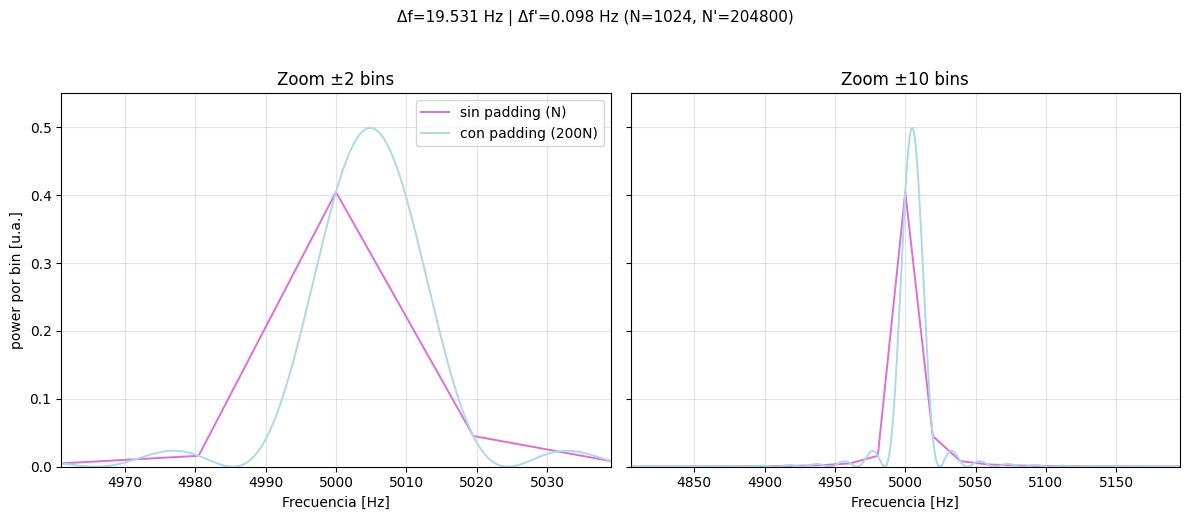

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros 
N, fs = 1024, 20_000
df = fs / N
n  = np.arange(N)

# Desintonía para ver leakage/scalloping
k0 = N/4 + 0.25
f0 = k0 * df

# Señal de potencia ~1: A = sqrt(2)
x = np.sqrt(2) * np.sin(2*np.pi*f0*n/fs)

# Periodograma 2-lados, power por bin (pico ideal ~0.5 si cae justo en bin)
def psd_2sided_bin(x, fs, nfft=None, N_norm=None):
    x = np.asarray(x, float).ravel()
    Nsig = len(x)
    if nfft is None: nfft = Nsig
    if N_norm is None: N_norm = Nsig
    X  = np.fft.fft(x, n=nfft)
    P2 = (np.abs(X)**2) / (N_norm**2)     
    f  = np.fft.fftfreq(nfft, d=1/fs)
    return np.fft.fftshift(f), np.fft.fftshift(P2)

# Sin padding vs padding grande 
mult = 200            # 200×N 
Npad = mult * N
dfp  = fs / Npad

f_no, P_no = psd_2sided_bin(x, fs, nfft=N,    N_norm=N)
f_hi, P_hi = psd_2sided_bin(x, fs, nfft=Npad, N_norm=N)

# --- Dos zooms lado a lado ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ylims = (0, 0.55)
f0c   = fs/4

def plot_zoom(ax, bins_zoom, title):
    win = bins_zoom * df
    ax.plot(f_no, P_no, color="orchid",  lw=1.4, label="sin padding (N)")
    ax.plot(f_hi, P_hi, color="lightblue",   lw=1.4, label=f"con padding ({mult}N)")
    ax.set_xlim(f0c - win, f0c + win)
    ax.set_ylim(*ylims)
    ax.set_title(title)
    ax.set_xlabel("Frecuencia [Hz]")
    ax.grid(True, alpha=0.35)

plot_zoom(axs[0], 2.0,  "Zoom ±2 bins")
plot_zoom(axs[1], 10.0, "Zoom ±10 bins")
axs[0].set_ylabel("power por bin [u.a.]")
axs[0].legend(loc="upper right")

fig.suptitle(f"Δf={df:.3f} Hz | Δf'={dfp:.3f} Hz (N={N}, N'={Npad})", y=1.03, fontsize=11)
plt.tight_layout()
plt.show()


---

### Resultados — (c) Zero padding

Con $N=1024$ y $f_s=20\,\text{kHz}$:

$$
N' = 10N = 10240,\qquad
\Delta f = \frac{f_s}{N} \approx 19.531~\text{Hz},\qquad
\Delta f' = \frac{f_s}{N'}=\frac{\Delta f}{10}\approx 1.953~\text{Hz}.
$$

**Qué se ve en los gráficos:**
- La forma del espectro no cambia: mismo lóbulo principal y mismos lóbulos laterales.  
  El padding solo *interpela* la DFT ⇒ aparecen *más puntos* en frecuencia.
- La *altura de los picos* se mantiene (escalé con $N_{\text{ref}}=N$), por lo tanto la potencia total no cambia.
- En el *zoom* se distingue mejor la desintonía de las tres senoidales  
  ($k_0=N/4$, $k_0=N/4+0.25$, $k_0=N/4+0.5$), pero el *leakage* y el *scalloping* siguen presentes.
- La potencia integrada $\sum_k S_{xx}[k]\Delta f'$ se mantiene $\approx 1$ (normalización unitaria).

**Conclusión.** El *zero padding* *no reduce* el leakage ni modifica la energía; solo hace más *fina* la rejilla en frecuencia.  
Es útil para *medir con más resolución* la ubicación del pico, pero *no reemplaza* el ventaneo si se busca atenuar lóbulos laterales.

---


## Conclusiones

- **(a) Desintonía:** cuando la senoidal no cae justo en un bin, aparece *leakage* y *scalloping* (el pico se reparte y baja). En bin exacto el pico queda súper concentrado.
- **(b) Parseval:** con el periodograma *unilateral* y el escalado correcto, la *potencia en tiempo* y la *potencia por integración de la PS* coinciden (las diferencias son numéricas y despreciables).
- **(c) Zero padding:** sólo *interpola* el espectro (más puntos y picos “más finos”) pero *no* reduce leakage ni scalloping ni cambia la energía. La potencia total se mantiene ≈ 1.

---

## Autoevaluación del aprendizaje

Resolví la tarea con seguridad

**¿Qué aprendí al hacer esta tarea?**
- A armar la *PSD unilateral* con el escalado que conserva la potencia.
- A verificar *Parseval* comparando tiempo vs. frecuencia de forma prolija.
- A usar *zero padding* para mejorar la *resolución en frecuencia* sin alterar la energía.
- A identificar visualmente *leakage* y *scalloping* y relacionarlos con la desintonía.

**¿Qué me quedó claro? ¿Qué me sigue costando?**
Me queda claro por qué cambia la forma del espectro cuando hay desintonía y por qué Parseval se cumple si el escalado está bien pero aun me cuesta elegir siempre el mejor tamaño de FFT y la ventana adecuada cuando quiero comparar señales distintas.

---

## Uso de IA

**¿Usé IA?** Sí: **ChatGPT**  
**Para:**  
EL formateo del Markdown (títulos, ecuaciones y secciones), algunoas correcciones de codigo para PSD y zero-padding y algunos plots de los graficos.

